# Working with Shapefiles and OSM Part II of II

**Author**: [Erika Fille Legara](www.erikalegara.net)

You are free to use (or change) this notebook for any purpose you'd like. However, please respect the [MIT License](https://github.com/eflegara/PythonMaps/blob/master/LICENSE)  that governs its use, and for copying permission.

Copyright © 2016 Erika Fille Legara

---
## Description

This recipe is the second of a series of Python notebooks on shapefiles and OSM files that I am working on. After going through the notebook, you should be able to plot maps as in the images below. 

![Metro Manila Maps](./img/maps.png "Metro Manila Maps")


First thing's first, import the necessary packages. The `Basemap` package is used for drawing and plotting maps (and also for reading shapefiles). The `shapefile` package provides read and write support for the ESRI Shapefile format.  

In [1]:
try:
    from mpl_toolkits.basemap import Basemap
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import PathPatch
    import shapefile
    import os.path
    import matplotlib.pyplot as plt
    import urllib
    %matplotlib inline
    import numpy as np
except:
    import traceback
    traceback.print_exc()
    raise ImportError('Something failed, see above.')

## Loading the shapefile for cities

In [2]:
phl2 = shapefile.Reader("PHL_adm_shp/PHL_adm2")

## Fields (Records) + Geometries

Now, let's pull out the shapes and records and obtain the bounding-boxes for each cities.

In [3]:
citiesRecs = phl2.shapeRecords()
cities_bbox = {}

for entry in citiesRecs:
    cities_bbox[entry.record[6]] = entry.shape.bbox

cities_bbox.items()[0:5]

[('Tagana-An',
  [125.52970123291061, 9.65027046203636, 125.70527648925791, 9.769089698791568]),
 ('Talitay',
  [124.32147979736328, 6.983870029449747, 124.41300964355484, 7.08224010467552]),
 ('Dumalneg',
  [120.79208374023438, 18.415330886840877, 120.88435363769545, 18.531850814819375]),
 ('Aloguinsan',
  [123.5244369506836, 10.143600463867188, 123.63102722167966, 10.248220443725543]),
 ('Bongabong',
  [121.24404144287121, 12.618599891662598, 121.55500030517587, 12.798540115356673])]

The first 20 cities.

In [4]:
print cities_bbox.keys()[0:20]

['Tagana-An', 'Talitay', 'Dumalneg', 'Aloguinsan', 'Bongabong', 'Villaviciosa', 'Solsona', 'Infanta', 'Malabon', 'Barobo', 'Minalin', 'Caramoran', 'San Jacinto', 'Mallig', 'Santa Ignacia', 'Tabuk City', 'Pandi', 'Tongkil', 'General Macarthur', 'General Emilio Aguinaldo']


## OpenStreetMap
[Downloading OSM data](http://wiki.openstreetmap.org/wiki/Downloading_data) is straightforward now that we have the bounding boxes.

In [5]:
getfile = urllib.URLopener()

### Download OSM for cities

Let's get the OSM data for each of the cities in Metro Manila. 

In [6]:
metro_manila = ["Manila", "Quezon City", "Pateros", "Kalookan City", "Las Piñas", "Makati City", 
                "Malabon", "Mandaluyong", "Marikina", "Muntinlupa", "Navotas", "Parañaque", "Pasay City", 
                "Pasig City", "Taguig", "Valenzuela"]

I use [XAPI](http://wiki.openstreetmap.org/wiki/XAPI) to download city information. According to [OSM's wiki page](http://wiki.openstreetmap.org/wiki/Downloading_data#Huge_amounts_of_data):

<blockquote>XAPI and Overpass API allow to download custom data sets like arbitrary bounding boxes, elements with specific tags, public transport networks or other features. [...] The API is limited to bounding boxes of about 0.5 degree by 0.5 degree and you should avoid using it if possible. For larger areas you might try to use XAPI [...]
</blockquote>

<span style="color:red; font-weight:bold">IMPORTANT NOTE</span>: If the code chunk results to a 504 error, the issue is on the server side (OSM overpass); not the code. You may have to wait to download again. 
> If a query is rejected due to too much resource consumption, this is now answered with HTTP status code 504

In [7]:
urlhead = "http://overpass.osm.rambler.ru/cgi/xapi_meta?*[bbox="
urltail = "]"

for k in metro_manila:
    url = urlhead + str(cities_bbox[k][0]) + "," + str(cities_bbox[k][1]) + "," + \
    str(cities_bbox[k][2]) + "," + str(cities_bbox[k][3]) + urltail
    
    if not os.path.exists("./cities_osm/"):
        print "Creating cities_osm directory..."
        os.makedirs("./cities_osm/")
        
    fname = "./cities_osm/"+ str(k)+".osm"
    
    if not os.path.isfile(fname): 
        try:
            getfile.retrieve(url, fname)
        except IOError as err:
            print "Whoops! Looks like the server is busy... consuming too much resource. Let's wait a bit."  
            print "Error: ", err
            break

We now have the OSM files for the cities we are interested in. Let's see what is inside an OSM file. Let's have a look at the first few lines of one OSM file. 

In [8]:
f = open("./cities_osm/Pasay City.osm",'rb')
for line in f.readlines()[0:4]:
    print line.strip("\n")
f.close()

<?xml version="1.0" encoding="UTF-8"?>
<osm version="0.6" generator="Overpass API">
<note>The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.</note>
<meta osm_base="2016-07-30T04:25:02Z"/>


Above, we are looking at the header of the file. The OSM files we have are XML files. I am not going to elaborate on this one, but if you want to learn more about the file formatting, please [follow this link](http://wiki.openstreetmap.org/wiki/OSM_XML).

> The major tools in the OSM universe use an XML format following a XML schema definition that was first used by the API only. Basically it is a list of instances of our data primitives (nodes, ways, and relations).

To read more about the different elements of an OSM file (or the data primitives), [follow this link](http://wiki.openstreetmap.org/wiki/Elements). As summarized in the site:


> Elements are the basic components of OpenStreetMap's conceptual data model of the physical world. They consist of

> - **nodes** (defining points in space),
> - **ways** (defining linear features and area boundaries), and
> - **relations** (which are sometimes used to explain how other elements work together).

> All of the above can have one or more associated tags (which describe the meaning of a particular element).

In this recipe, we are more interested in the **nodes** and the **ways**. Below, we show how a **node** element looks and how a **way** element looks.

#### Node Element

In [9]:
f = open("./cities_osm/Pasay City.osm",'rb')
for line in f.readlines()[50004:50020]:
    print line.strip("\n")
f.close()

  <node id="2408221587" lat="14.5165490" lon="120.9914944" version="2" timestamp="2013-08-06T08:57:48Z" changeset="17238376" uid="81841" user="schadow1">
    <tag k="name" v="Bay 9 Aguinaldo"/>
    <tag k="source" v="Schadow1 Expeditions"/>
    <tag k="tourism" v="information"/>
  </node>
  <node id="2408221588" lat="14.5169370" lon="120.9909399" version="2" timestamp="2013-08-06T08:57:48Z" changeset="17238376" uid="81841" user="schadow1">
    <tag k="addr:city" v="Parañaque"/>
    <tag k="addr:housename" v="Southwest IPTS"/>
    <tag k="addr:postcode" v="1701"/>
    <tag k="addr:street" v="Macapagal Boulevard"/>
    <tag k="amenity" v="place_of_worship"/>
    <tag k="denomination" v="catholic"/>
    <tag k="name" v="Chapel"/>
    <tag k="religion" v="christian"/>
    <tag k="source" v="Schadow1 Expeditions"/>
  </node>


#### Way Element
You will see that the **way** element have **nd** "children"---these are the nodes associated to that particular way. Using the **nd** reference, we can see information on that particular node.

In [10]:
f = open("./cities_osm/Pasay City.osm",'rb')
for line in f.readlines()[500010:500050]:
    print line.strip("\n")
f.close()

  <way id="387706703" version="1" timestamp="2015-12-25T18:09:16Z" changeset="36163163" uid="11126" user="seav">
    <nd ref="3909506583"/>
    <nd ref="3909506582"/>
    <nd ref="3909506581"/>
    <nd ref="3909506580"/>
    <nd ref="3909506578"/>
    <nd ref="3909506579"/>
    <nd ref="3909506584"/>
    <nd ref="3909506585"/>
    <nd ref="3909506586"/>
    <nd ref="3909506587"/>
    <nd ref="3909506588"/>
    <nd ref="3909506589"/>
    <tag k="highway" v="service"/>
  </way>
  <way id="387706704" version="1" timestamp="2015-12-25T18:09:16Z" changeset="36163163" uid="11126" user="seav">
    <nd ref="3909506593"/>
    <nd ref="3909506613"/>
    <nd ref="3909506615"/>
    <nd ref="3909506616"/>
    <nd ref="3909506618"/>
    <nd ref="3909506622"/>
    <nd ref="3909506620"/>
    <nd ref="3909506617"/>
    <nd ref="3909506611"/>
    <nd ref="3909506610"/>
    <nd ref="3909506607"/>
    <nd ref="3909506595"/>
    <tag k="highway" v="service"/>
    <tag k="oneway" v="yes"/>
    <tag k="servi

To easily manipulate the OSM files, I use the Python package `osmread`. It is a simple library for reading the files; it allows us to parse a file and choose (or filter) specific element types.

In [11]:
from osmread import parse_file, Way, Node, Relation

For example, if I want to obtain all the highways in the file, I need to track all **Way** elements and look at their tags---whether or not they have the *highway* tag. Check the `getHighways()` function written below.

In [12]:
def getHighWays(osmfile):
    all_nodes = {}
    way_nodes = []

    for entity in parse_file(osmfile):
        if isinstance(entity, Node):
            all_nodes[entity.id] = [entity.lon, entity.lat]
        if isinstance(entity, Way) and 'highway' in entity.tags:
            way_nodes.append(list(entity.nodes))
    return all_nodes, way_nodes

We are also taking note of all the nodes associated with a *highway* **Way** entity; remember the **nd** tag. We use this later for plotting. We implement the same process to look for *buildings* in the file. Since a building is coded with a set of nodes, we look for a **Way** element with the *building* tag. See the `getBuildings()` function below.

In [13]:
def getBuildings(osmfile):
    all_nodes = {}
    way_nodes = []
    tags = []
    for entity in parse_file(osmfile):
        if isinstance(entity, Node):
            all_nodes[entity.id] = [entity.lon, entity.lat]
        if isinstance(entity, Way) and "building" in entity.tags:
            way_nodes.append(list(entity.nodes))
    return all_nodes, way_nodes

### Going back to shapefiles
Now that we have the highway and building entities and the associated shape (lat, lon) information, we are ready to plot them. There may be other ways that exist out there, but I have opted to create individual shapefiles for these. For the roads, we write polylines (shapefile); for the buildings, polygons.

In [14]:
def createPolyLine(all_nodes, way_nodes, region):
    w = shapefile.Writer(shapefile.POLYLINE)

    lon_list = []
    lat_list = []

    for way in way_nodes:
        parts = []
        for node in way:
            lon = float(all_nodes[node][0])
            lat = float(all_nodes[node][1])
            parts.append([lon,lat])
            lon_list.append(lon)
            lat_list.append(lat)
        w.poly(parts=[parts], shapeType=shapefile.POLYLINE)
        
    w.field('ID')
    w.field('SECOND_FLD') ## This is an arbitrary field
    
    for i in range(len(way_nodes)): 
        w.record(i,'Line') ## This an arbitrary information 
    
    w.save(region)
    
    return lon_list, lat_list

In [15]:
def createPolygon(all_nodes, way_nodes, region):
    w = shapefile.Writer(shapefile.POLYGON)

    lon_list = []
    lat_list = []

    for way in way_nodes[:-1]:
        parts = []
        for node in way:
            lon = float(all_nodes[node][0])
            lat = float(all_nodes[node][1])
            parts.append([lon,lat])
            lon_list.append(lon)
            lat_list.append(lat)
        w.poly(parts=[parts])
        
    w.field('ID')
    w.field('SECOND_FLD') ## This is an arbitrary field
    for i in range(len(way_nodes)):
        w.record(i,'Polygon') ## This an arbitrary information 
    
    w.save(region)
    return lon_list, lat_list

Using Pasay City as example, we will be generating the following files: [`Pasay City line.dbf`, `Pasay City line.shp`, `Pasay City line.shx`, `Pasay City poly.dbf`, `Pasay City poly.shp`, `Pasay City line.shx`]. Using the shapefiles, we can now plot the buildings and road networks using [Basemap](http://matplotlib.org/basemap/).

### Plotting Roads and Buildings

In [16]:
def plotRoadNetwork(lon_list, lat_list, whichLine, fname):
    _ = plt.clf()
    _ = plt.figure(figsize=(8,8))
    m = Basemap(llcrnrlon=min(lon_list)-0.001,
                llcrnrlat=min(lat_list)-0.001,
                urcrnrlon=max(lon_list)+0.001,
                urcrnrlat=max(lat_list)+0.001,
                resolution='i', projection='tmerc', lat_0 = np.mean(lat_list), lon_0 = np.mean(lon_list))
    _ = m.readshapefile(whichLine,whichLine, color="#0f0f13", zorder=2, linewidth=0.3)
    _ = m.readshapefile(whichLine,whichLine, color="#a3adb8", zorder=2, linewidth=0.05)
    _ = m.drawmapboundary(color='white',  fill_color="#ffffff", linewidth=1)
    _ = plt.text(1,2,"by @eflegara", fontsize=2, color="gray")
    plt.show()
    #_ = plt.savefig("./maps/" +fname, dpi=300, bbox_inches="tight")
    #_ = plt.clf()

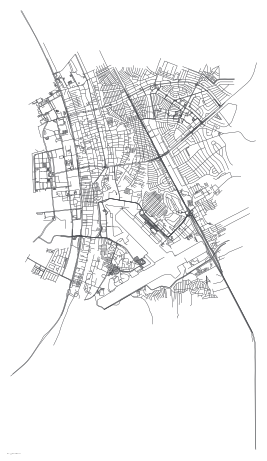

In [17]:
region = "Pasay City"

all_nodes, way_nodes = getHighWays("./cities_osm/" + str(region) + ".osm")
lon_list, lat_list = createPolyLine(all_nodes, way_nodes, region + " line")
_ = plotRoadNetwork( lon_list, lat_list, region + " line", region + "-line"+".png")

In [18]:
def plotBuildings(lon_list, lat_list, whichPoly, fname):
    _ = plt.clf()
    _ = plt.figure(figsize=(8,8))
    m = Basemap(llcrnrlon=min(lon_list)-0.001,
                llcrnrlat=min(lat_list)-0.001,
                urcrnrlon=max(lon_list)+0.001,
                urcrnrlat=max(lat_list)+0.001,
                resolution='i', projection='tmerc', lat_0 = np.mean(lat_list), lon_0 = np.mean(lon_list))
    _ = m.readshapefile(whichPoly, whichPoly, color="#000000", zorder=2, linewidth=0.1)
    _ = m.drawmapboundary(color='white',  fill_color="#ffffff", linewidth=1)
    _ = m.fillcontinents(color='#ffffff', lake_color ="#ffffff")
    _ = plt.text(1,2,"by @eflegara", fontsize=2, color="gray")
    _ = plt.show()
    #_ = plt.savefig("./buildings/" + fname, dpi=900, bbox_inches="tight")
    #_ = plt.clf()


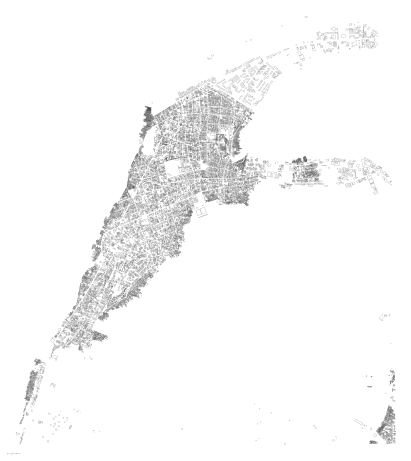

In [19]:
region = "Cavite City"

all_nodes, way_nodes = getBuildings("./cities_osm/" + str(region) + ".osm")
lon_list, lat_list = createPolygon(all_nodes, way_nodes, region + " poly")
_ = plotBuildings( lon_list, lat_list, region + " poly", region + "-poly"+".png")

### Together

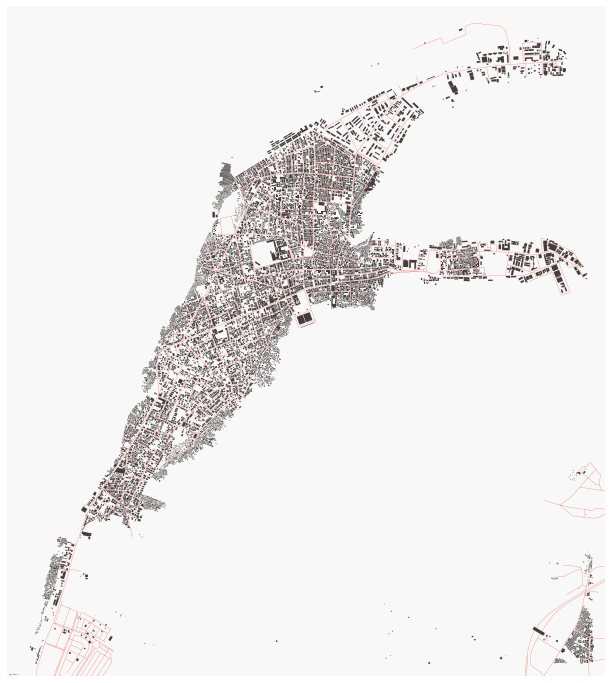

In [20]:
interests = ["Cavite City", "Manila", "Taguig", "Makati City", "Iloilo City",
            "Pasig City", "Kalookan City", "Mandaluyong", "Pasay City", 
            "Baguio City", "Cagayan de Oro City", "Quezon City", "Navotas", "Parañaque",
            "Valenzuela"]

for region in interests[0:1]:
    _ = plt.clf()
    _ = plt.figure( figsize=(12,12))
    m = Basemap(llcrnrlon = cities_bbox[region][0]-0.001,
                    llcrnrlat = cities_bbox[region][1]-0.001,
                    urcrnrlon = cities_bbox[region][2]+0.001,
                    urcrnrlat = cities_bbox[region][3]+0.001,
                    resolution='i', projection='tmerc', 
                    lat_0 = np.mean([cities_bbox[region][1],cities_bbox[region][3]]), 
                    lon_0 = np.mean([cities_bbox[region][0],cities_bbox[region][2]]))

    m.drawmapboundary(fill_color='#F8F8F8', linewidth=0)
    m.fillcontinents(color='#F8F8F8',lake_color='#F8F8F8')
    m.drawcoastlines(color="#ffffff", linewidth=0.01)

    m.readshapefile("./city_shapefiles/" + str(region) + " poly", "region_poly", 
                    drawbounds=False)
    m.readshapefile("./city_shapefiles/" + str(region) + " line", "region_line", 
                    color="#EF2E18", zorder=2, linewidth=0.2)
    patches   = []
    ax = plt.gca()
    for info, shape in zip(m.region_poly_info, m.region_poly):
        #print info
        patches.append( Polygon(np.array(shape), True) )

    ax.add_collection(PatchCollection(patches, facecolor= '#443D3C', 
                                      edgecolor='#443D3C', linewidths=0, zorder=2))

    _ = plt.text(10, 20, "@eflegara", fontsize=2, color="#443D3C") 
    _ = plt.show()
    #plt.savefig(str(region)+"-sample.jpg", dpi=900, bbox_inches="tight")
    #plt.clf()

## Metro Manila
Some of the city maps I have generated using the code above.
![Metro Manila Maps](./img/maps.png "Metro Manila Maps")
